In [2]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
import geopandas
import glob
import os
from pyorbital import astronomy
from datetime import datetime, timedelta
from shapely import geometry

## Data Exploration

In [3]:
ml_gdf = geopandas.read_file('../../data/interim/h8_ml_apr_sep_2019_clean.geojson')

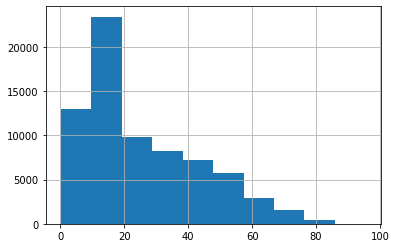

In [4]:
ml_gdf['sunglint_angle'].hist()

In [5]:
ml_gdf.loc[ml_gdf['truth_flag'] == -1, 'truth_flag'] = 1

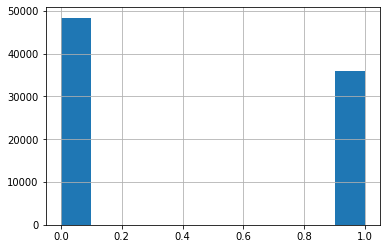

In [6]:
%matplotlib inline
_ = ml_gdf['truth_flag'].hist()

In [6]:
predict_gdf = ml_gdf.copy()

In [7]:
predict_gdf = predict_gdf.reset_index(drop=True)

## Sun-glint filter as a baseline model

Here we create a baseline model using sunglint filter. If sunglint angle is small (e.g ~ 0), the probability of the hotspot being a real hotspot should be low.

In [8]:
MAX_SG_ANGLE = 90.0
predict_gdf['sg_model_prob'] = np.clip(predict_gdf['sunglint_angle']/ MAX_SG_ANGLE, a_min=0, a_max=1.0)
predict_gdf.loc[predict_gdf['id_hs'].isna(), 'sg_model_prob'] = 0

The focus of the ML model is to improve existing JAXA Hotspot product - specifically on reducing false alarm rate while maintaining same level of performance. We make the following assumptions:

* From operational experience, the JAXA hotspot product appears to be able to pick up most fires, but at a cost of very high false alarm rate.
* We assume that if the baseline AHI hotspot product is unable to detect the **Missed Detections**, then we assume that the fire inherently could not be detected by the JAXA contextual algorithm.
* Small fires which cannot be detected by the AHI sensor are not of interest to operational users.

Stage 1:
Therefore, we will first train a model and assess its performance using dataset that excludes **Missed Detections** that were not picked up by the JAXA hotspot product.

Stage 2:
Performance of the trained model will be reasssesed later using dataset that included missed detections.

In [17]:
#For Stage 1
predict_features = ['t07', 't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 'ref3', 'ref4', 'sunglint_angle']
predict_gdf_no_FN = predict_gdf.dropna(subset=predict_features)

NameError: name 'predict_gdf' is not defined

In [10]:
len(predict_gdf.loc[predict_gdf['truth_flag'] == 1]), len(predict_gdf) - len(predict_gdf_no_FN)

(36038, 12082)

## Feature Selection 

In [11]:
corr_features = [*predict_features, 'truth_flag']

### Correlation Matrix

(14.0, -1.0)

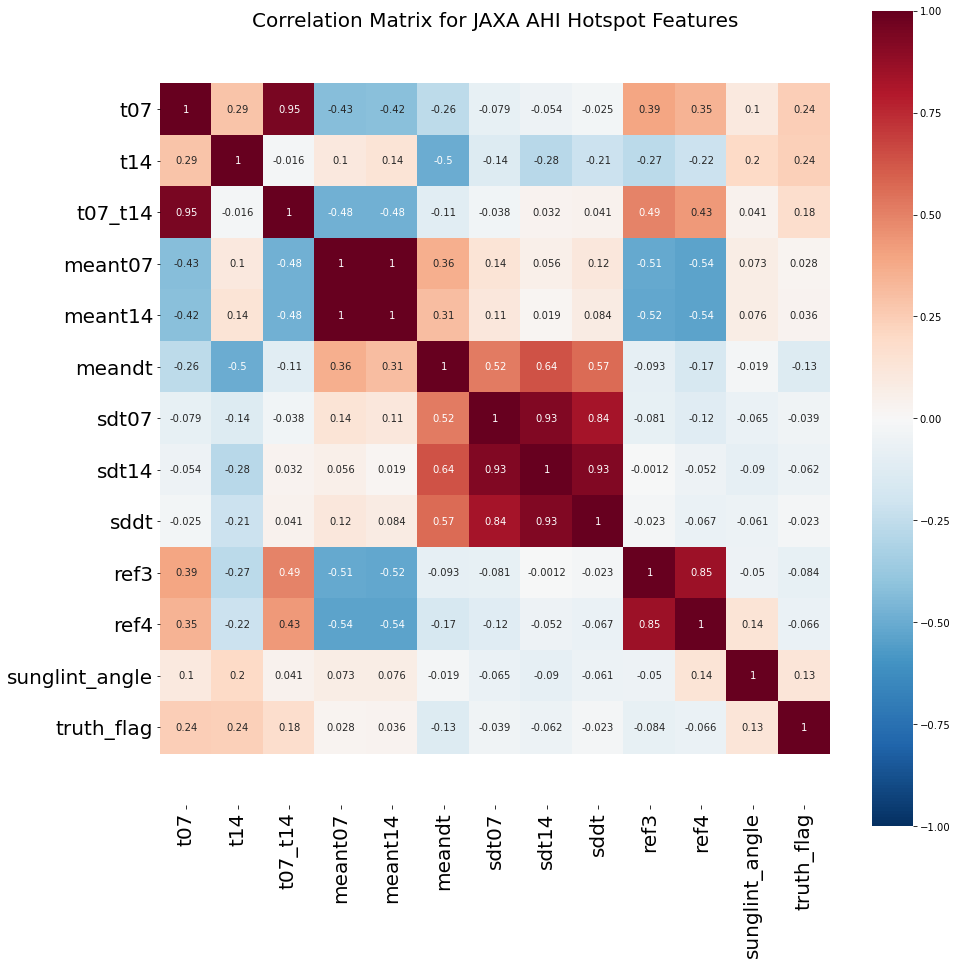

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrx = predict_gdf_no_FN[corr_features].corr()
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax = sns.heatmap(corr_matrx, vmin=-1.0, vmax=1.0, annot=True, square=True, cmap='RdBu_r',annot_kws={"size": 10})
ax.tick_params(labelsize=20)
plt.yticks(rotation='horizontal')
ax.set_title('Correlation Matrix for JAXA AHI Hotspot Features', {'fontsize':20})


b, t = plt.ylim() # discover the values for bottom and top
b += 1 # Add 0.5 to the bottom
t -= 1 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

Looking at the correlation matrix heatmap, we can roughly group the features into 4 clusters:
    
1. `t07`, `t14`, `t07_t14` - absolute brightness temperatures of SWIR and IR channels
2. `meant07`, `meant14`, `meandt` - mean of brightness temperatures of SWIR and IR channels for neighbouring pixels
3. `sdt07`, `sdt14`, `sddt` - standard deviations of brightness temperatures of SWIR and IR channels for neighbouring pixels
4. `ref3`, `ref4`, `sunglint_angle` - solar reflectivity channels associated with visible and NIR channels, as well as sun glint reflections

The above is consistent with the contextual algorithm developed for fire detection. It is reasonably to use these features but we will explore using dimension reductionality technique to see if we can further improve the prediction.

We also examine the relative importance and relationship of the features with the ground truth label `truth_flag`. 

In [13]:
predict_gdf_no_FN[corr_features].corr()['truth_flag'].sort_values()

meandt           -0.132836
ref3             -0.083910
ref4             -0.066161
sdt14            -0.061951
sdt07            -0.039473
sddt             -0.023150
meant07           0.027913
meant14           0.036420
sunglint_angle    0.129207
t07_t14           0.178357
t14               0.238801
t07               0.243234
truth_flag        1.000000
Name: truth_flag, dtype: float64

The following features have negative correlations
* `ref3` `ref4`

In a way, it makes sense as presence of solar channels contaminates the SWIR channels and contributes to false alarms. 

The following features have relatively low importance, which was slightly surprising. These are part of the contextual algorithm which compares values of neighbouring pixels with center pixel.
* `std14`, `sdt07`, `sddt`, `meant07`, `meant14`

The following features have relatively high importance.
* `meandt` has a relatively high importance. It's not clear why it has a negative correlation. Perhaps due to the presence of false alarms data.
* `t07_t14`. This is one of the key parameters used to calculate temperature difference, and is known to be a good predictor for fire activity.
* `t07`, `t14`. Higher brightness temperatures typically indicate presence of fire activity.
* `sunglint_angle`. Sunglint is the main reason behind false alarm. Small sunglint angle means there's strong reflection from the sun glint off the surface into the satellite sensor.


We will need to examine the coefficients later after running through a Linear Logistic Regression model.



### Violin Plot
We make violin plots to visualise the features and label.

It's apparently quite difficult to draw conclusion based on visual inspection.

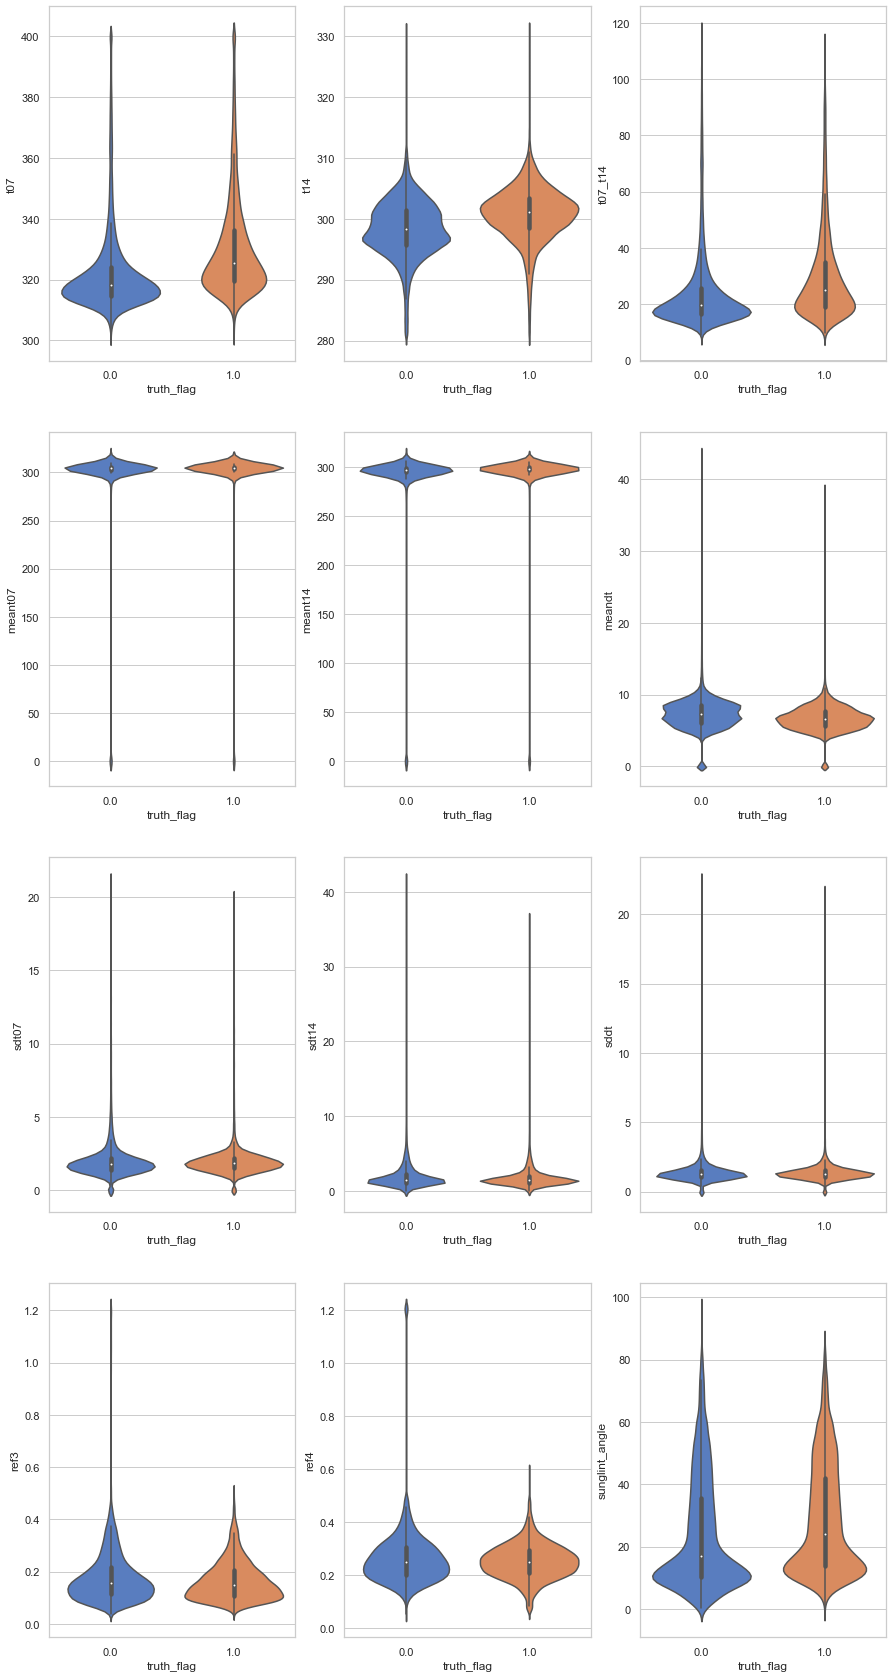

In [14]:
import seaborn as sns
sns.set(style="whitegrid")
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = 4, 3
for index, feature in enumerate(predict_features):
    ax = fig.add_subplot(nrow,ncol,index + 1)
    _ = sns.violinplot(x=predict_gdf_no_FN['truth_flag'], y=predict_gdf_no_FN[feature], palette="muted", cut=2)
    axes.append(ax)

### Dimension Reduction

These features were deliberately prepared with our domain knowledge. For exploration purpose, I'll use **Principal Component Analysis** to reduce the number of features. First, we will apply Standard Scaling to transform the data.

In [15]:
from sklearn.preprocessing import StandardScaler
std_scale_features = []
predict_gdf_no_FN_scaled = predict_gdf_no_FN[[*predict_features, 'truth_flag']]
std_scaler = StandardScaler()
predict_gdf_no_FN_scaled[predict_features] = std_scaler.fit_transform(predict_gdf_no_FN_scaled[predict_features])

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Anaconda3\envs\fred_linux\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Anaconda3\envs\fred_linux\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

After applying standard scaling, the values of the features are transformed.

In [16]:
predict_gdf_no_FN_scaled.head()

,t07,t14,t07_t14,meant07,meant14,meandt,sdt07,sdt14,sddt,ref3,ref4,sunglint_angle,truth_flag
0,-0.320900,-0.199377,-0.271902,0.105830,0.050314,0.962916,-0.906657,-0.618319,-0.645863,-0.388013,-0.405163,1.584343,1.0
1,-0.445611,-0.254245,-0.384725,0.117143,0.094806,0.412317,-0.526245,-0.503685,-0.410861,-0.792932,-0.340422,0.677850,1.0
2,-0.206422,-0.271127,-0.129704,0.100541,0.055857,0.780124,-0.756031,-0.661996,-0.612908,-0.433004,-0.340422,1.859881,1.0
3,1.473661,-0.271127,1.624071,0.100607,0.045454,0.955118,-0.923265,-0.581367,-0.436345,0.016907,-0.146201,0.231319,1.0
4,1.219122,-0.055878,1.290273,0.087645,0.059836,0.493911,-0.719820,-0.586543,-0.303280,-0.531984,-0.932336,-0.796583,1.0


In [17]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(predict_gdf_no_FN_scaled[predict_features])
pca.explained_variance_ratio_

array([3.40197767e-01, 2.65615582e-01, 1.26907232e-01, 9.17099014e-02,
       7.43952048e-02, 5.50257293e-02, 2.12041015e-02, 1.30831497e-02,
       9.73805908e-03, 2.12327325e-03, 6.78503020e-14, 1.85254338e-31])

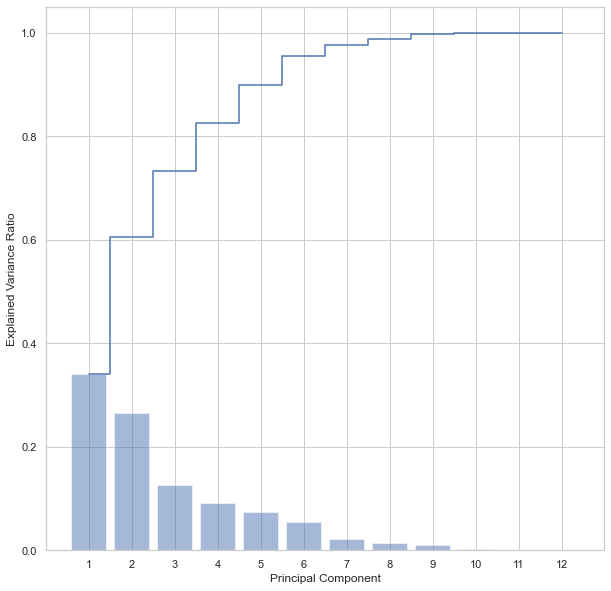

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
_ = ax.bar(range(1, len(predict_features) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
_ = plt.step(range(1, len(predict_features) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
_ = plt.xlabel('Principal Component')
_ = plt.ylabel('Explained Variance Ratio')
_ = ax.xaxis.set_ticks(np.arange(1, len(predict_features) + 1, 1))

We see that about the first 9/12 components can explain about 99% of the explained variance. Now we plot the violin plot again.

In [19]:
pca_nmax = 9

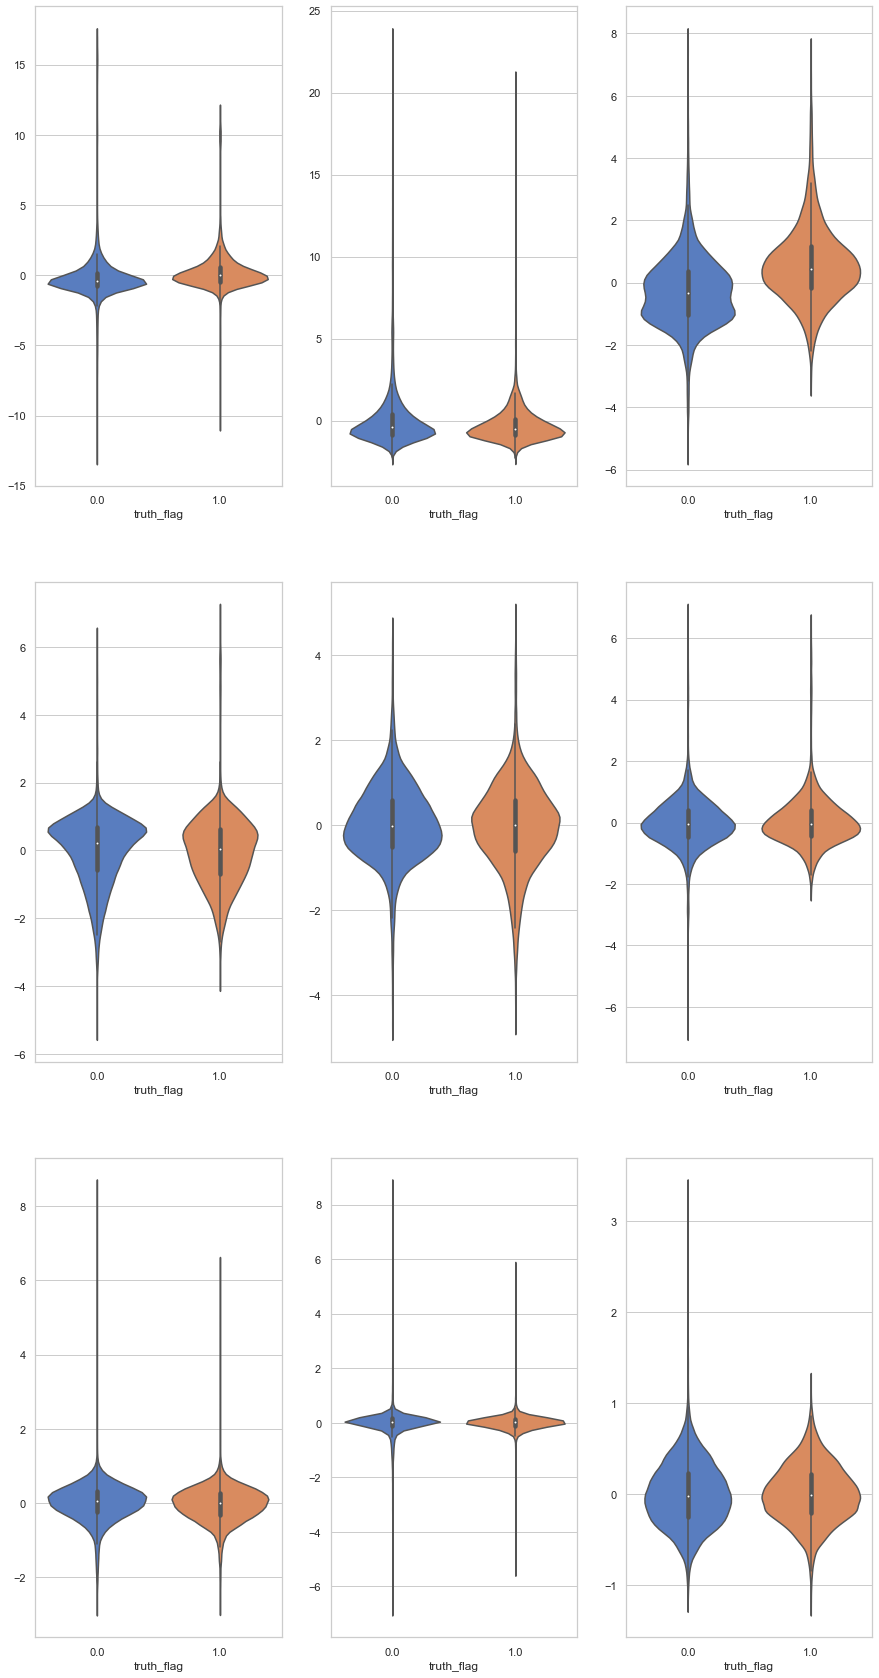

In [20]:
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = pca_nmax/3, 3
for i in range(0, pca_nmax, 1):
    ax = fig.add_subplot(nrow,ncol, i + 1)
    _ = sns.violinplot(x=predict_gdf_no_FN_scaled['truth_flag'], y=X_train_pca[:,i], palette="muted", cut=2)
    axes.append(ax)

However, we still don't see a very clear pattern visually. We'll now examine each principal component and check the relative contribution of the original features.

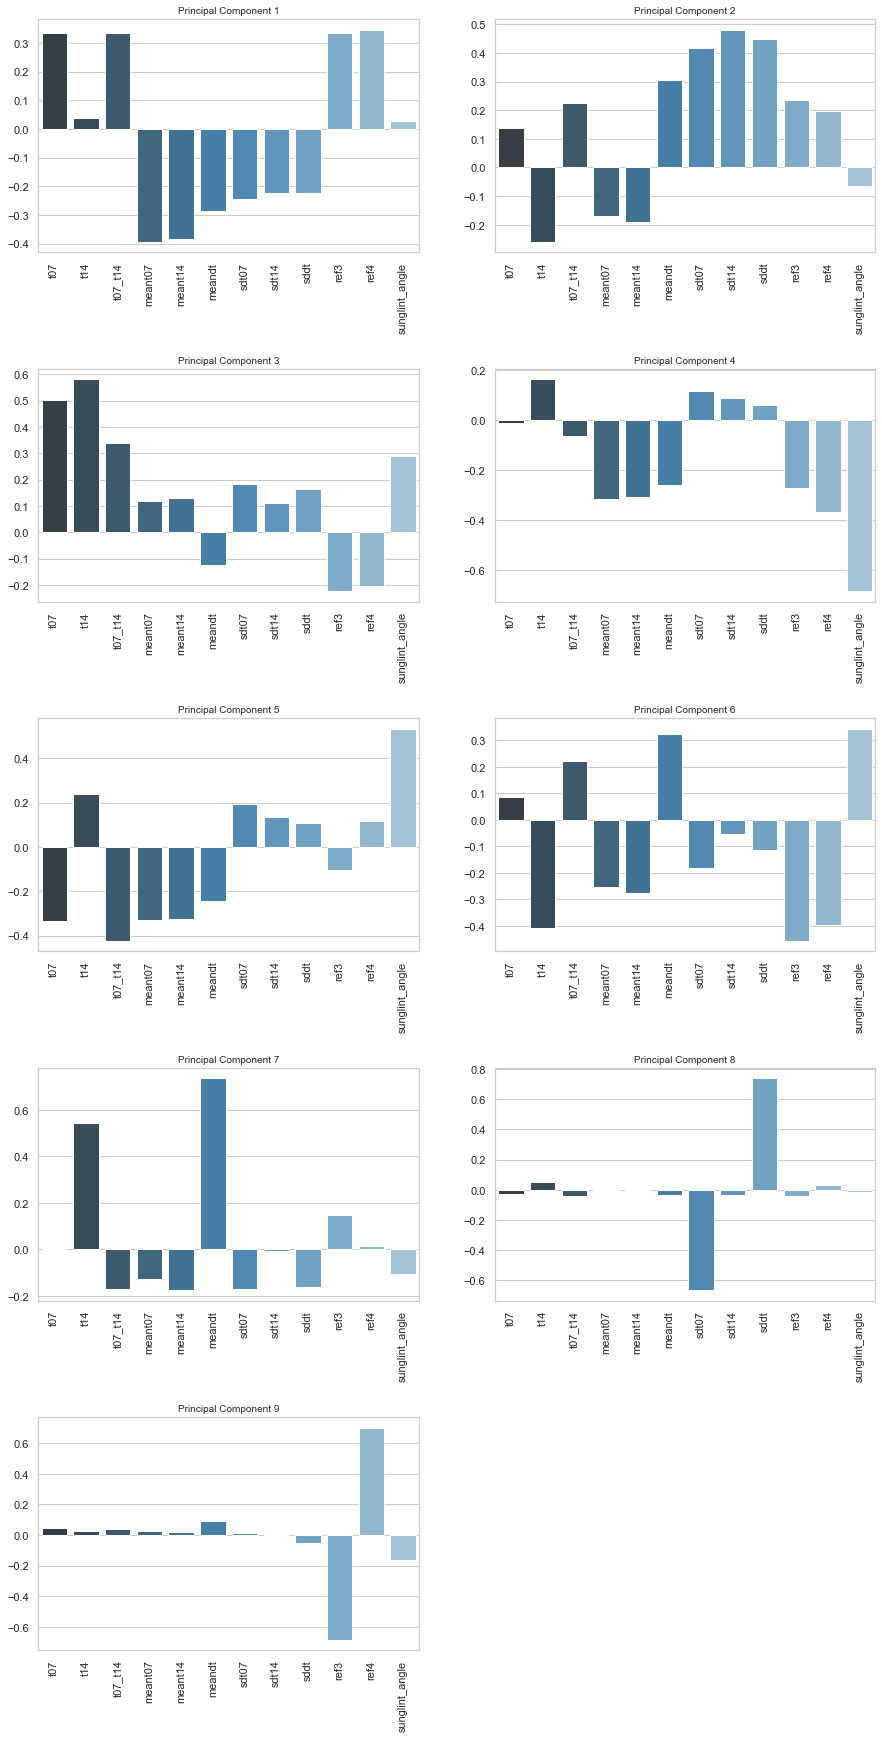

In [21]:
fig = plt.figure(figsize=(15,30))
axes = []
nrow, ncol = int(pca_nmax/2) + 1, 2
for i in range(0, pca_nmax, 1):
    ax = fig.add_subplot(nrow,ncol, i + 1)
    ax = sns.barplot(y=pca.components_[i], x=predict_features, palette="Blues_d")
    _ = plt.xticks(rotation='vertical')
    ax.set_title(f'Principal Component {i+1}', {'fontsize':10})
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)  
    axes.append(ax)

### Understanding the Principal Components

We'll try to make a sense of what the principal components represent, physically. We look at the top 3 PCs.

| Principal Component   |      Description      | 
|----------|:-------------:|
| PC 1 |  Highly reflective sun glint induced hotspots. |
| PC 2 |  Difficult to draw conclusion. Possibly hotspots near water bodies.  | 
| PC 3 |  High temperature hotspots with cooler neighbouring pixels. Typically indicates a real fire activity. This is shown on the violin plot by the bigger separation between the two labelled classes. |
    

## Model Selection

We choose a list of baseline classifiers, with the following choices of hyperparameters for grid search. We'll pass these classifiers through **k-fold** cross validation. After the **k-fold** cross-validation is done, we will assess and pick the best baseline algorithm. Therefore, we will do one more training using the complete training set with the chosen classifier.

The choices of baseline classifiers are:
* Logistic Classifier
* Random Forest Classifier
* Stochastic Gradient Classifier
* Gradient Boosting Classifier
* Linear Discriminant Analysis
* Neural Network

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

In [23]:
#Setup the grid search params
model_param_json = {
    'LR': {
        'clf': LogisticRegression(fit_intercept=True, penalty='l1', solver='liblinear'),
        'param_grid': [
            { 'clf__C': [0.5, 1.0, 1.5, 2.5],
             'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear', 'saga']},
        ]
    },
    'SGD': {
        'clf': SGDClassifier(fit_intercept=True, n_jobs=-1),
        'param_grid': [
            { 'clf__loss':['hinge', 'log', 'squared_loss', 'epsilon_insensitive'],
             'clf__penalty': ['l1', 'l2', 'elasticnet'],
             'clf__alpha': [0.0001, 0.0005, 0.001]},
        ]
    },
    'GB': {
        'clf': GradientBoostingClassifier(),
        'param_grid': [
            { 'clf__loss':['exponential'],
             'clf__n_estimators': [100, 500],
             'clf__min_samples_split': [2, 10, 25],
             'clf__max_depth': [3, 5],
             'clf__min_samples_leaf': [1, 3, 5]},
        ]
    },
    'LDA': {
        'clf': LinearDiscriminantAnalysis(),
        'param_grid': [
            {'clf__solver': ['svd']},
        ]
    },
    'NN': {
        'clf': MLPClassifier(),
        'param_grid': [
            { 'clf__hidden_layer_sizes':[10, 50, 100],
             'clf__activation': ['relu', 'tanh'],
             'clf__solver': ['adam'],
             'clf__learning_rate': ['constant', 'invscaling'],
             'clf__learning_rate_init': [0.0005, 0.001, 0.005, 0.01]},
        ]
    },
    'RF': {
        'clf': RandomForestClassifier(max_depth=5, random_state=123, n_jobs=-1),
        'param_grid': [
            { 'clf__n_estimators':[100, 500],
             'clf__max_depth': [3, 5],
             'clf__min_samples_split': [2, 10, 25],
            'clf__min_samples_leaf': [1, 3, 5]},
        ]
    }
}

In [23]:
#    'SVM': {
#        'clf': SVC(kernel='rbf', gamma='auto', probability=True),
#        'param_grid': [
#            { 'clf__C':[0.5, 1, 2, 10, 100],
#             'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
#        ]
#    }

## Model Training & Cross-Validation
Note that the distribution of the **True/False** fire labels is not equal and thus we will need to balance the labels for training.
We first use  `StratifiedKFold` to split up into **training** and **test** datasets **k-fold** while keeping the ratio of True/False fire labels. This helps us to assess the performance of model in real-life. For each of the **training** dataset, we use resampling without replacement to downsample the majority class - **False** fire label so that the ratio of the two class labels is equal.

In [24]:
from sklearn.model_selection  import train_test_split

training_df, test_df = train_test_split(predict_gdf_no_FN[[*predict_features, 'truth_flag']], test_size=0.2, random_state=123, shuffle=True)

training_minority_df = training_df[(training_df['truth_flag'] == 1)]
training_majority_df = training_df[(training_df['truth_flag'] == 0)]

training_downsampled_df = resample(training_majority_df, replace=False, 
                                   n_samples=len(training_minority_df), random_state=123)

training_balanced_df = pd.concat([training_downsampled_df, training_minority_df])


In [25]:
model_eval_df = pd.DataFrame(columns=['best_estimator', 'roc', 'params'])
cv_results_df = pd.DataFrame()

In [170]:
model_eval = {}
for model in model_param_json.keys():
    
    print (f'We are now training {model}')
    
    clf_pipeline = Pipeline([('std', std_scaler), ('clf', model_param_json[model]['clf'])])
        
    gs_clf = GridSearchCV(estimator=clf_pipeline, 
                           param_grid=model_param_json[model]['param_grid'], 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=3, 
                           refit=True,
                           pre_dispatch='2*n_jobs')
    gs_clf.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])

    print (f'Best estimator : {gs_clf.best_estimator_}')
    print (f'Best ROC score : {gs_clf.best_score_}')
    print (f'Best params : {gs_clf.best_params_}')
    
    model_eval['best_estimator'] = gs_clf.best_estimator_
    model_eval['roc'] = gs_clf.best_score_
    model_eval['params'] = gs_clf.best_params_
    
    temp_cv_df = pd.DataFrame(gs_clf.cv_results_)
    temp_cv_df['model'] = model
    cv_results_df = pd.concat([cv_results_df, temp_cv_df])
    
    model_eval_df = model_eval_df.append(model_eval, ignore_index=True)

We are now training LR
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   17.8s finished
C:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LogisticRegression(C=0.5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best ROC score : 0.7235257108722911
Best params : {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'saga'}
We are now training SGD
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   18.7s finished
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 SGDClassifier(alpha=0.0005, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='log',
                               max_iter=1000, n_iter_no_change=5, n_jobs=-1,
                               penalty='l1', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)
Best ROC score : 0.7239853593471939
Best params : {'clf__alpha': 0.0005, 'clf__loss': 'log', 'clf__penalty': 'l1'}
We are now training GB
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 19.1min finished


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1,
                                            loss='exponential', max_depth=5,
                                            max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=500,
                                            n_iter_no_change=None,
               

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
C:\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass '

Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 LinearDiscriminantAnalysis(n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)
Best ROC score : 0.7211869371185659
Best params : {'clf__solver': 'svd'}
We are now training NN
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 17.5min finished


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 MLPClassifier(activation='relu', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=100,
                               learning_rate='invscaling',
                               learning_rate_init=0.005, max_iter=200,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)
Best ROC score : 0.8049537233341744
Best params : {'clf__activation': '

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  9.2min finished


Best estimator : Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=5,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=10,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)
Best 

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [26]:
#cv_results_df.to_csv('cv_result_df.csv')
cv_results_df = pd.read_csv('cv_result_df.csv')

## Cross Validation Results

In this part, we examine the results of model training and pick the best model from here.

Text(0.5, 1.0, 'Model Test Score/Variance Comparison')

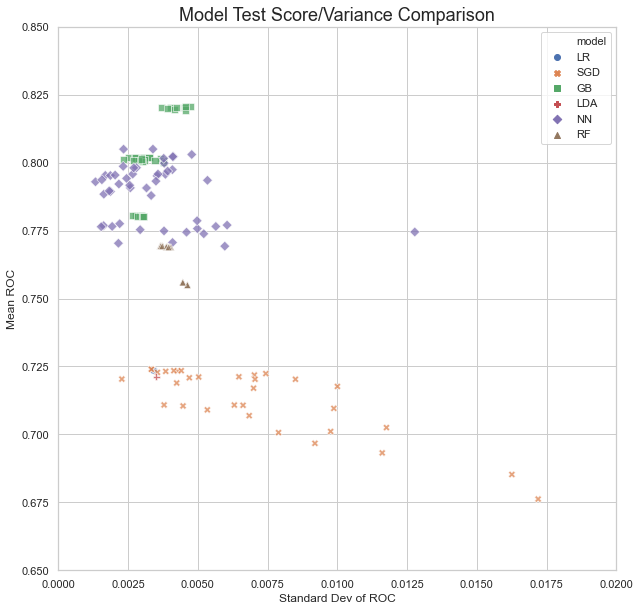

In [27]:
fig = plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="std_test_score", y="mean_test_score", alpha=0.75, hue="model", style="model", data=cv_results_df, s=50)
ax.set_ylim(bottom=0.65, top=0.85)
ax.set_xlim(left=0, right=0.02)
ax.set_xlabel('Standard Dev of ROC', {'fontsize': 12})
ax.set_ylabel('Mean ROC', {'fontsize': 12})
ax.set_title('Model Test Score/Variance Comparison', {'fontsize': 18})

In [28]:
#model_eval_df.to_csv('model_eva_df.csv')
model_eval_df = pd.read_csv('model_eva_df.csv')
model_eval_df['model'] = model_eval_df['best_estimator'].apply(lambda x: x.split("'clf',\n                 ")[1])
model_eval_df['model'] = model_eval_df['model'].apply(lambda x: x[:x.index("(")])
model_eval_df.drop(columns=['Unnamed: 0'], inplace=True)
model_eval_df = model_eval_df.sort_values(by='roc').reset_index(drop=True)

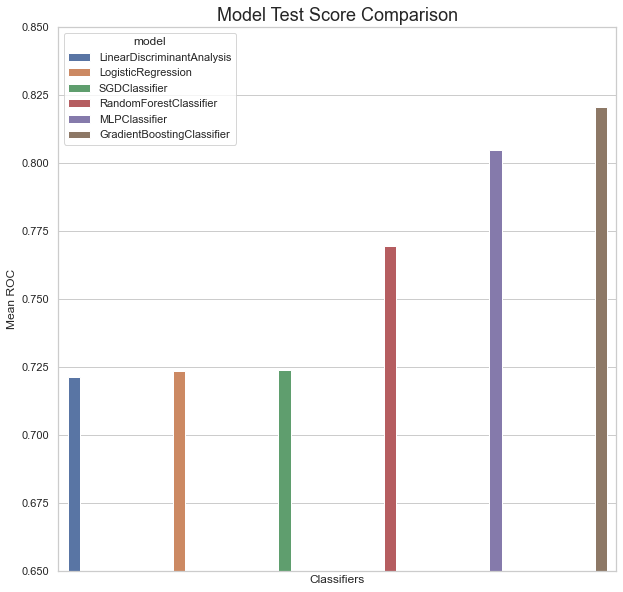

In [29]:
fig = plt.figure(figsize=(10,10))
ax = sns.barplot(x="model", y="roc", hue="model", data=model_eval_df)
ax.set_ylim(bottom=0.65, top=0.85)
ax.set_xlabel('Classifiers', {'fontsize': 12})
ax.set_ylabel('Mean ROC', {'fontsize': 12})
ax.set_title('Model Test Score Comparison', {'fontsize': 18})
_ = ax.xaxis.set_ticks([])

Here we see that **Gradient Boosting Classifier** and **Neural Network** model have the best test scores. The linear models such as logistic regression isn't performing too badly as well, as the ROC score is still a decent 0.72. We also see that the variances of these models are relatively low, suggesting that the model is not so prone to overfitting. 

We also know that the best parameters for each class of the models are as followed.

In [30]:
model_eval_df

,best_estimator,roc,params,model
0,"Pipeline(memory=None,\n steps=[('std',...",0.721187,{'clf__solver': 'svd'},LinearDiscriminantAnalysis
1,"Pipeline(memory=None,\n steps=[('std',...",0.723526,"{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__so...",LogisticRegression
2,"Pipeline(memory=None,\n steps=[('std',...",0.723985,"{'clf__alpha': 0.0005, 'clf__loss': 'log', 'cl...",SGDClassifier
3,"Pipeline(memory=None,\n steps=[('std',...",0.769338,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",RandomForestClassifier
4,"Pipeline(memory=None,\n steps=[('std',...",0.804954,"{'clf__activation': 'relu', 'clf__hidden_layer...",MLPClassifier
5,"Pipeline(memory=None,\n steps=[('std',...",0.820654,"{'clf__loss': 'exponential', 'clf__max_depth':...",GradientBoostingClassifier


In [31]:
model_eval_df.loc[model_eval_df['model'] == 'LogisticRegression', 'params'] =  "{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'saga', 'clf__multi_class': 'ovr'}"

Now, we will assess the final performance of the models with the full `training_balanced_df` and `test_df` dataset. We'll also check if standard scaling of the input data improves the performance in any way.

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss

for index, row in model_eval_df.iterrows():
    #with standardisation scaling applied
    pipe = eval(row['best_estimator'])
    pipe.steps[0] = ('std', std_scaler)
    pipe.set_params(**eval(row['params']))
    
    #no standardisation scaling applied
    pipe_noscale = eval(row['best_estimator'])
    pipe_noscale.steps = [pipe_noscale.steps[1]]
    pipe_noscale.set_params(**eval(row['params']))
        
    pipe.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
    y_prob = pipe.predict_proba(test_df[predict_features])[:,1]
    y_pred = pipe.predict(test_df[predict_features])
    
    model_eval_df.loc[index, 'roc_final'] = roc_auc_score(y_true=test_df['truth_flag'], y_score=y_prob)
    model_eval_df.loc[index, 'brief_score_loss'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    model_eval_df.loc[index, 'f1_score'] = f1_score(y_true=test_df['truth_flag'], y_pred=y_pred)
    
    pipe_noscale.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
    y_prob = pipe_noscale.predict_proba(test_df[predict_features])[:,1]
    y_pred = pipe_noscale.predict(test_df[predict_features])
    
    model_eval_df.loc[index, 'roc_final_noscale'] = roc_auc_score(y_true=test_df['truth_flag'], y_score=y_prob)
    model_eval_df.loc[index, 'bsl_noscale'] = brier_score_loss(y_true=test_df['truth_flag'], y_prob=y_prob)
    model_eval_df.loc[index, 'f1_noscale'] = f1_score(y_true=test_df['truth_flag'], y_pred=y_pred)

C:\Anaconda3\envs\fred_linux\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda3\envs\fred_linux\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda3\envs\fred_linux\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
C:\Anaconda3\envs\fred_linux\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any 

In [33]:
model_eval_df

,best_estimator,roc,params,model,roc_final,brief_score_loss,f1_score,roc_final_noscale,bsl_noscale,f1_noscale
0,"Pipeline(memory=None,\n steps=[('std',...",0.721187,{'clf__solver': 'svd'},LinearDiscriminantAnalysis,0.725128,0.213284,0.564446,0.725128,0.213284,0.564446
1,"Pipeline(memory=None,\n steps=[('std',...",0.723526,"{'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__so...",LogisticRegression,0.727551,0.213353,0.568146,0.707955,0.221930,0.552519
2,"Pipeline(memory=None,\n steps=[('std',...",0.723985,"{'clf__alpha': 0.0005, 'clf__loss': 'log', 'cl...",SGDClassifier,0.723288,0.216957,0.570066,0.689771,0.393644,0.553676
3,"Pipeline(memory=None,\n steps=[('std',...",0.769338,"{'clf__max_depth': 5, 'clf__min_samples_leaf':...",RandomForestClassifier,0.769104,0.199053,0.601041,0.769103,0.199053,0.601041
4,"Pipeline(memory=None,\n steps=[('std',...",0.804954,"{'clf__activation': 'relu', 'clf__hidden_layer...",MLPClassifier,0.812300,0.181820,0.643273,0.751012,0.210597,0.592734
5,"Pipeline(memory=None,\n steps=[('std',...",0.820654,"{'clf__loss': 'exponential', 'clf__max_depth':...",GradientBoostingClassifier,0.827115,0.173419,0.654677,0.827004,0.173463,0.654501


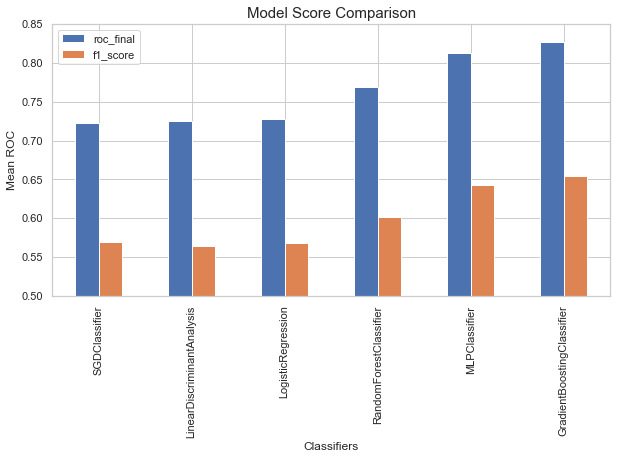

In [34]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = model_eval_df.groupby(['model'])[['roc_final', 'f1_score']].mean().sort_values(by=['roc_final']).plot.bar(ax=ax)
ax.set_ylim(bottom=0.5, top=0.85)
ax.set_xlabel('Classifiers', {'fontsize': 12})
ax.set_ylabel('Mean ROC', {'fontsize': 12})
_ = ax.set_title('Model Score Comparison', {'fontsize': 15})

It's clear that **Gradient Boosting Classifier** has both the highest *ROC* and *F1* scores.

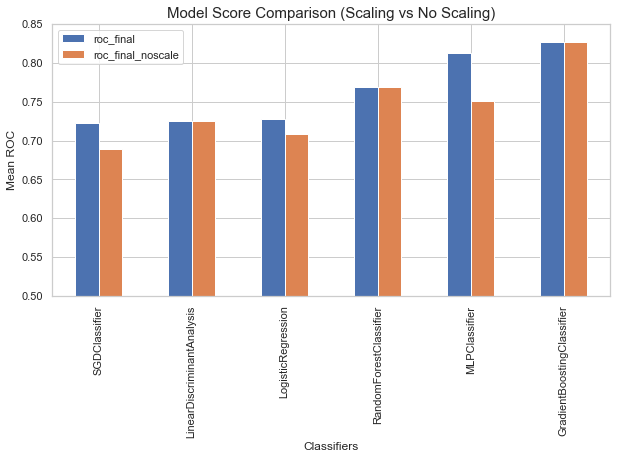

In [35]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = model_eval_df.groupby(['model'])[['roc_final', 'roc_final_noscale']].mean().sort_values(by=['roc_final']).plot.bar(ax=ax)
ax.set_ylim(bottom=0.5, top=0.85)
ax.set_xlabel('Classifiers', {'fontsize': 12})
ax.set_ylabel('Mean ROC', {'fontsize': 12})
_ = ax.set_title('Model Score Comparison (Scaling vs No Scaling)', {'fontsize': 15})

We see that in general, scaling improves the model performance (as expected). Some models such as neural network, SGD classifier and logistic regression are more sensitive to scaling.

Now that we have identified **Gradient Boosting Classifier** as the best model, let's compare the machine learning models against the baseline Sun Glint Filter model.

In [36]:
#Add the sun glint baseline model
MAX_SG_ANGLE = 90.0
test_df['sg_model_prob'] = np.clip(test_df['sunglint_angle']/ MAX_SG_ANGLE, a_min=0, a_max=1.0)

roc_sg = roc_auc_score(y_true=test_df['truth_flag'], y_score=test_df['sg_model_prob'])
bsl_sg = brier_score_loss(y_true=test_df['truth_flag'], y_prob=test_df['sg_model_prob'])
model_eval_df = model_eval_df.append({'model': 'SunGlintFilter', 'roc_final': roc_sg, 'brief_score_loss': bsl_sg}, ignore_index=True)

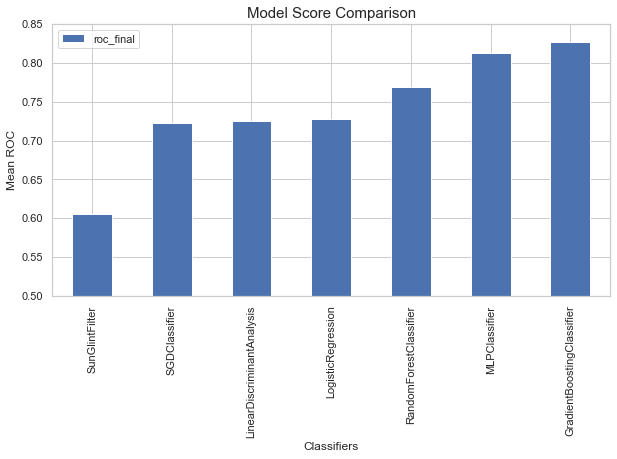

In [37]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax = model_eval_df.groupby(['model'])[['roc_final']].mean().sort_values(by=['roc_final']).plot.bar(ax=ax)
ax.set_ylim(bottom=0.5, top=0.85)
ax.set_xlabel('Classifiers', {'fontsize': 12})
ax.set_ylabel('Mean ROC', {'fontsize': 12})
_ = ax.set_title('Model Score Comparison', {'fontsize': 15})

In [38]:
best_estimator = model_eval_df.loc[model_eval_df['model']=='GradientBoostingClassifier', 'best_estimator'].values[0]
best_pipe = eval(best_estimator)
best_pipe.steps[0] = ('std', std_scaler)

best_params = model_eval_df.loc[model_eval_df['model']=='GradientBoostingClassifier', 'params'].values[0]
best_pipe.set_params(**eval(best_params))

best_pipe.fit(training_balanced_df[predict_features], training_balanced_df['truth_flag'])
y_prob = pipe.predict_proba(test_df[predict_features])[:,1]

C:\Anaconda3\envs\fred_linux\lib\site-packages\sklearn\ensemble\_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


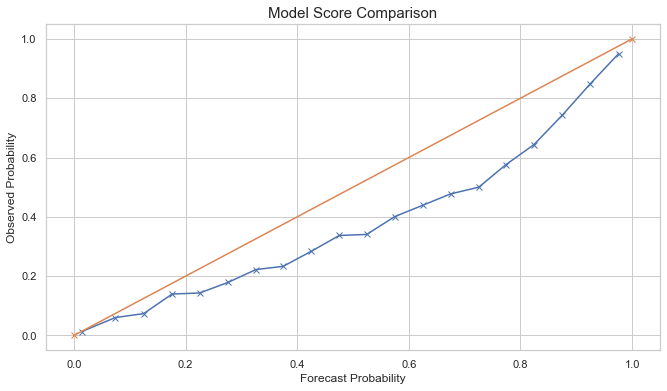

In [39]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_df['truth_flag'], y_prob, n_bins=20)
fig = plt.figure(figsize=(11,6))
ax = fig.add_subplot()
ax.plot(prob_pred, prob_true, marker='x')
ax.plot([0, 1], [0, 1], marker='x')
ax.set_xlabel('Forecast Probability')
ax.set_ylabel('Observed Probability')
_ = ax.set_title('Model Score Comparison', {'fontsize': 15})

We also need to assess the reliability of the model probability forecast. From the reliability diagram, we can see that the model has the tendency to overforecast.

## Learning Curve

In [40]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer


def plot_learning_curve(estimator, title, X, y, ax=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ax : axis

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, = \
    learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, 
                   train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")

    return plt

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\envs\\fred_linux\\lib\\site-packages\\matplotlib\\pyplot.py'>

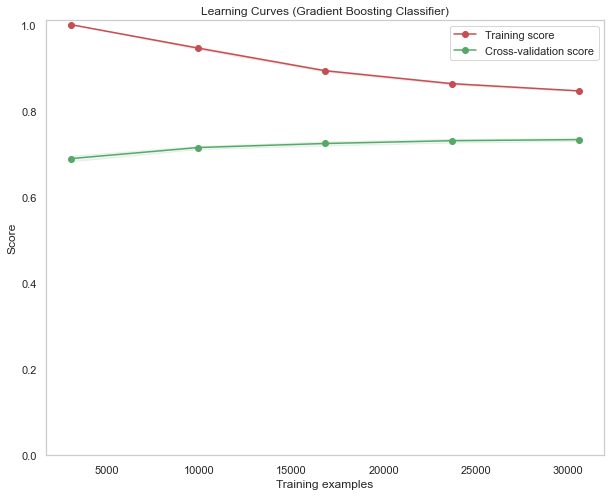

In [41]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
title = "Learning Curves (Gradient Boosting Classifier)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

lc_pipe = eval(best_estimator)
lc_pipe.steps[0] = ('std', std_scaler)
lc_pipe.set_params(**eval(best_params))

plot_learning_curve(lc_pipe, title, training_balanced_df[predict_features], training_balanced_df['truth_flag'], ax=ax, ylim=(0.0, 1.01),
                    cv=cv, n_jobs=4)

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true = test_df['truth_flag'], y_score = y_prob)
csi = 1/((1/(1-fpr)) + (1/tpr) - 1)
roc = roc_auc_score(y_true = test_df['truth_flag'], y_score = y_prob)

fpr_sg, tpr_sg, thresholds_sg = roc_curve(y_true = test_df['truth_flag'], y_score = test_df['sg_model_prob'])
csi_sg = 1/((1/(1-fpr_sg)) + (1/tpr_sg) - 1)
roc_sg = roc_auc_score(y_true = test_df['truth_flag'], y_score = test_df['sg_model_prob'])

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


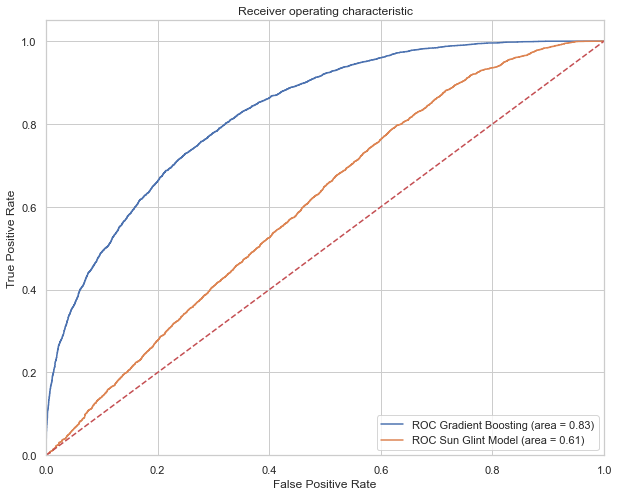

In [43]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr, tpr, label='ROC Gradient Boosting (area = %0.2f)' % roc)
ax.plot(fpr_sg, tpr_sg, label='ROC Sun Glint Model (area = %0.2f)' % roc_sg)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


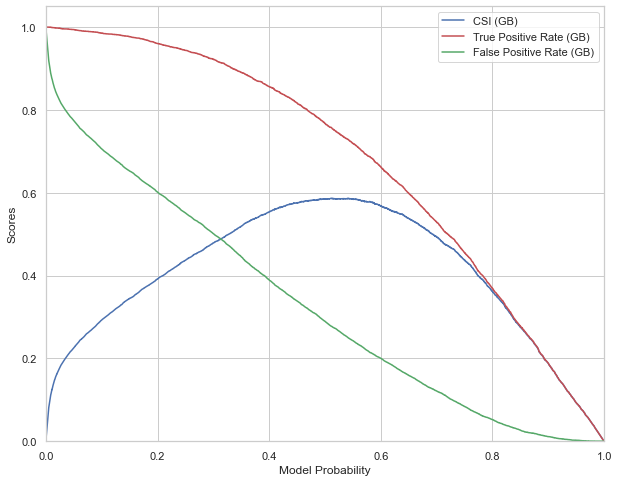

In [44]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds, csi, 'b', label='CSI (GB)')
plt.plot(thresholds, tpr, 'r', label='True Positive Rate (GB)')
plt.plot(thresholds, fpr, 'g', label='False Positive Rate (GB)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.legend(loc="top right")

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


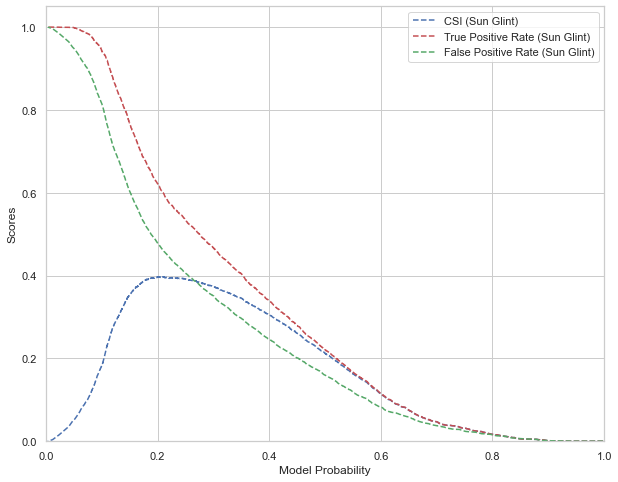

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds_sg, csi_sg, 'b--', label='CSI (Sun Glint)')
plt.plot(thresholds_sg, tpr_sg, 'r--', label='True Positive Rate (Sun Glint)')
plt.plot(thresholds_sg, fpr_sg, 'g--', label='False Positive Rate (Sun Glint)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.legend(loc="top right")

In [46]:
print (f"Best CSI: {csi.max()}")
print (f"Best TPR: {tpr[csi.argmax()]}")
print (f"Best FPR: {fpr[csi.argmax()]}")
print (f"Best Probability Threshold: {thresholds[csi.argmax()]}")

Best CSI: 0.5868348772707148
Best TPR: 0.757801198594751
Best FPR: 0.2776912695941036
Best Probability Threshold: 0.5110895903365692


## Assessing Model Performance with Missed Detections

In [47]:
predict_gdf['gb_prob'] = 0
predict_gdf.loc[~predict_gdf.id_hs.isna(), 'gb_prob'] = best_pipe.predict_proba(predict_gdf.loc[~predict_gdf.id_hs.isna(), predict_features])[:, 1]

In [48]:
fpr_real, tpr_real, thresholds_real = roc_curve(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['gb_prob'])
csi_real = 1/((1/(1-fpr_real)) + (1/tpr_real) - 1)
roc_real = roc_auc_score(y_true = predict_gdf['truth_flag'], y_score = predict_gdf['gb_prob'])

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


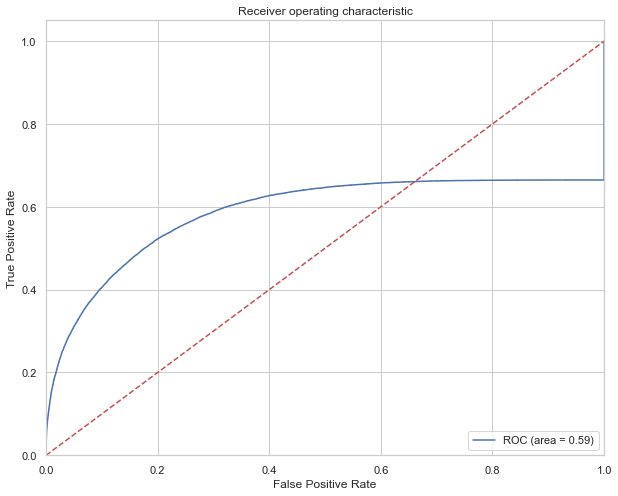

In [49]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
ax.plot(fpr_real, tpr_real, label='ROC (area = %0.2f)' % roc_real)
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

C:\Anaconda3\envs\fred_linux\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # This is added back by InteractiveShellApp.init_path()


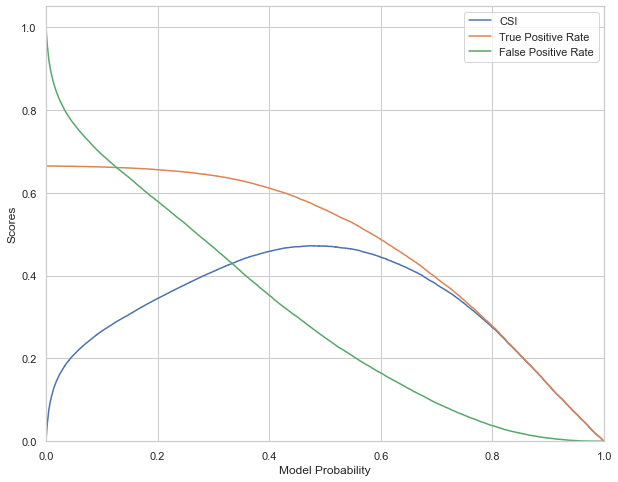

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.plot(thresholds_real, csi_real, label='CSI')
plt.plot(thresholds_real, tpr_real, label='True Positive Rate')
plt.plot(thresholds_real, fpr_real, label='False Positive Rate')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Model Probability')
ax.set_ylabel('Scores')
ax.legend(loc="top right")

In [51]:
print (f"Best CSI: {csi_real.max()}")
print (f"Best TPR: {tpr_real[csi_real.argmax()]}")
print (f"Best FPR: {fpr_real[csi_real.argmax()]}")
print (f"Best Probability Threshold: {thresholds_real[csi_real.argmax()]}")

Best CSI: 0.472098834341533
Best TPR: 0.5754758865641822
Best FPR: 0.27562910623527953
Best Probability Threshold: 0.4740910918004453


In [52]:
feature_impt_dict = {'feature': predict_features, 'weight': best_pipe.steps[1][1].feature_importances_}
feature_impt_df = pd.DataFrame(feature_impt_dict)

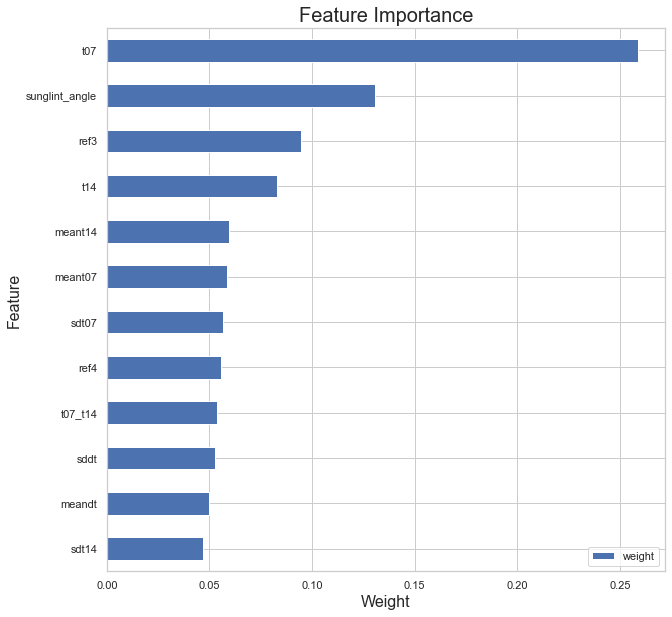

In [53]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
_ = feature_impt_df.sort_values(by=['weight']).plot.barh(x='feature', ax=ax)
ax.set_title('Feature Importance', fontsize=20)
_ = ax.set_ylabel('Feature', fontsize=16)
_ = ax.set_xlabel('Weight', fontsize=16)

In [2]:
#save model params
import pickle
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
#dump(best_pipe, '../../models/h8_gradientboosting_best_pipe_sklearn_0.22.sav') 
best_pipe = load('../../models/h8_gradientboosting_best_pipe_sklearn_0.22.sav') 

In [3]:
best_pipe

Pipeline(memory=None,
         steps=[('std',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1,
                                            loss='exponential', max_depth=5,
                                            max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=10,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=500,
                                        

In [19]:
from sklearn import tree
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
clf = best_pipe.steps[1][1].estimators_[5][0]
cn=['Non-fire', 'Fire']

export_graphviz(clf, out_file='tree.dot', 
                feature_names = predict_features,
                class_names = cn,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

!dot -Tpng tree.dot -o tree.png -Gdpi=600

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.727347 to fit


In [658]:
def compute_sun_glint_angle(sat_angle):
    """Compute the sun glint angle. Sun glint angle is defined as the angle difference between reflected solar beam and
    the satellite view/zenith angle, from the satellite reference frame. If the angle is small, it means that the
    reflected solar beam is seen by the satellite as sun glint.

    The eqn of sun glint is
        cos (theta_g) = cos (theta_v) * cos (theta_s) - sin (theta_v) * sin (theta_s) * cos (phi), where
        theta_g = sun glint angle, theta_v = satellite view/zenith angle, theta_s = solar zenith angle,
        phi = relative azimuth angle (difference between solar and satellite azimuth angle)

    For more info, refer to "An Enhanced Contextual Fire Detection Algorithm for MODIS" by Louis Giglio et al 2003
    https://doi.org/10.1016/S0034-4257(03)00184-6

    Args:
        sat_angle (dict): Dict of satellite angles: {
                        'viewzenang' (float): satellite view/zenith angle,
                        'solarzenang' (float): solar zenith angle,
                        'relazang' (float): relative azimuth angle ,
                         }

    Returns:
        sun_glint_angle (float): Angle of sun glint in degrees

    """
    theta_v = np.radians(sat_angle['viewzenang'])
    theta_s = np.radians(sat_angle['solarzenang'])
    phi = np.radians(sat_angle['relazang'])
    cos_sunglint = np.cos(theta_v) * np.cos(theta_s) - (np.sin(theta_v) * np.sin(theta_s) * np.cos(phi))
    sun_glint_rad = np.arccos(cos_sunglint)
    sun_glint_angle = np.degrees(sun_glint_rad)

    return sun_glint_angle

In [659]:
def parse_jaxa_hotspot_txt(file_path):
    """
    Parse the JAXA Himawari-8/9 AHI hotspot text file and insert attrs into the Pandas DataFrame

    Args:
        file_path (str): File path to the JAXA Himawari-8/9 hotspot .csv
          
    Returns:
        hs_df (obj): DataFrame obj that contains attr of Himawari-8/9 hospot
        
    """
    hs_ahi_df = pd.DataFrame()
    cols_to_use_list = [0, 2, *(i for i in range(7,27))]
    date_col_list = [0]
    names_list = ['date', 'satellite', 'lon', 'lat', 'viewzenang', 'viewazang', 'pixwid', 'pixlen', 't07',   
                  't14', 't07_t14', 'meant07', 'meant14', 'meandt', 'sdt07', 'sdt14', 'sddt', 
                  'ref3', 'ref4', 'fire_idx', 'fire', 'test1_6']
        

    for file in glob.glob(file_path):
            
        try:
            print (f'Reading {file}')
            temp_hs_ahi_df = pd.read_csv(file, sep=",", skiprows=[0], \
                                         header=None, usecols=cols_to_use_list, \
                                         names=names_list, \
                                         parse_dates=date_col_list)
            temp_hs_ahi_df['satellite'] = 'Himawari-8/9'
        except Exception as e:
            print (f'Error reading {file}')
            print (e)
            continue

        if len(temp_hs_ahi_df) > 0:
                   
            try:
                temp_hs_ahi_df['solarazang'] = temp_hs_ahi_df.apply( \
                    lambda x: np.degrees(astronomy.get_alt_az(x['date'], x['lon'], x['lat'])[1]), axis=1)
                temp_hs_ahi_df['solarzenang'] = temp_hs_ahi_df.apply( \
                    lambda x: astronomy.sun_zenith_angle(x['date'], x['lon'], x['lat']), axis=1)
                temp_hs_ahi_df['relazang'] = temp_hs_ahi_df['solarazang'] - temp_hs_ahi_df['viewazang']
                temp_hs_ahi_df['sunglint_angle'] = temp_hs_ahi_df.apply(compute_sun_glint_angle, axis=1)
            except Exception as e:
                temp_hs_ahi_df['sunglint_angle'] = np.nan
                
            try:
                temp_hs_ahi_df.loc[(temp_hs_ahi_df['date'].dt.hour >= 0) \
                                   & (temp_hs_ahi_df['date'].dt.hour <= 11), 'daynight'] = 'day'
                temp_hs_ahi_df.loc[temp_hs_ahi_df['date'].dt.hour > 11, \
                                   'daynight'] = 'night'
                temp_hs_ahi_df['date'] = temp_hs_ahi_df['date'].dt.strftime( \
                    "%d/%m/%Y %H:%M:%S")
            except Exception as e:
                date_from_file = datetime.strptime(filename[4:17], "%Y%m%d_%H%M")
                temp_hs_ahi_df['date'] = date_from_file.strftime("%d/%m/%Y %H:%M:%S")

        hs_ahi_df = pd.concat([hs_ahi_df, temp_hs_ahi_df])

    if len(hs_ahi_df) > 0:
        hs_ahi_df = hs_ahi_df.reset_index(drop=True)

    return hs_ahi_df

In [660]:
h8_sep11 = parse_jaxa_hotspot_txt(file_path="../../data/raw/hotspots/ahi/H08_20190911_0*_L2WLFbet_FLDK*.csv")

Reading ../../data/raw/hotspots/ahi\H08_20190911_0000_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0010_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0020_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0030_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0040_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0050_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0100_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0110_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0120_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0130_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0140_L2WLFbet_FLDK.06001_06001.csv
Reading ../../data/raw/hotspots/ahi\H08_20190911_0150_L2WLFbet_FLDK.06001_06

In [672]:
h8_sep11['gb_prob'] = best_pipe.predict_proba(h8_sep11[predict_features])[:,1]

In [674]:
h8_sep11.to_csv('11-09-2019.csv')